# Setup

In [96]:
import time
import pandas as pd
import numpy as np
from scipy.interpolate import interpn
from scipy import ndimage as ndi

from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier

from skimage.morphology import watershed
from skimage import morphology, color, segmentation, data, filters, draw
from skimage.color import label2rgb
from skimage.transform import resize
from skimage.feature import canny
from skimage.exposure import histogram

from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from spectral_cube import SpectralCube, BooleanArrayMask
from astropy.utils.data import download_file
from astropy import units as u
from astropy import wcs

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)

%matplotlib inline

## Import and Shape Data

In [136]:
noise_data = fits.open('data/U6805.lmap.fits')
noise_data[0].header['CTYPE3'] = 'FREQ'
noise_data[0].header['CUNIT3'] = 'Hz'
rest_vel = noise_data[0].header['VELR']*(u.m/u.s)
rest_freq = noise_data[0].header['FREQR']*u.Hz
noise_cube = SpectralCube.read(noise_data)
noise_data.close()

In [132]:
hi_datafile = download_file(
    'http://data.astropy.org/tutorials/FITS-cubes/reduced_TAN_C14.fits',
    cache=True, show_progress=True)
hi_data = fits.open(hi_datafile)  # Open the FITS file for reading
hi_cube = SpectralCube.read(hi_data)  # Initiate a SpectralCube
hi_data.close()  # Close the FITS file - we already read it in and don't need it anymore!

## Visualise Data

In [144]:
def plot_cube(cube_data, mask=0, vmin=0, vmax=200, rest_value=None, velocity_convention=None):
    spec_cube = cube_data.with_spectral_unit(u.km/u.s, rest_value=rest_value, velocity_convention=velocity_convention)
    moment_0 = spec_cube.moment(order=0)  # Zero-th moment
    moment_1 = spec_cube.moment(order=1)  # First moment
    hi_column_density = moment_0 * 1.82 * 10**18 / (u.cm * u.cm) * u.s / u.K / u.km
    # Initiate a figure and axis object with WCS projection information
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection=moment_1.wcs)

    # Display the moment map image
    im = ax.imshow(moment_1.hdu.data, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    ax.invert_yaxis()  # Flips the Y axis

    # Add axes labels
    ax.set_xlabel("Galactic Longitude (degrees)", fontsize=16)
    ax.set_ylabel("Galactic Latitude (degrees)", fontsize=16)

    # Add a colorbar
    cbar = plt.colorbar(im, pad=.07)
    cbar.set_label('Velocity (km/s)', size=16)

    # Overlay set of RA/Dec Axes
    overlay = ax.get_coords_overlay('fk5')
    overlay.grid(color='white', ls='dotted', lw=2)
    overlay[0].set_axislabel('Right Ascension (J2000)', fontsize=16)
    overlay[1].set_axislabel('Declination (J2000)', fontsize=16)
    # Overplot column density contours
    if mask == 0:
        ax.contour(hi_column_density, cmap='Greys_r')
    else:
        ax.contour(mask, cmap='Greys_r')
    fig.tight_layout()

Noise

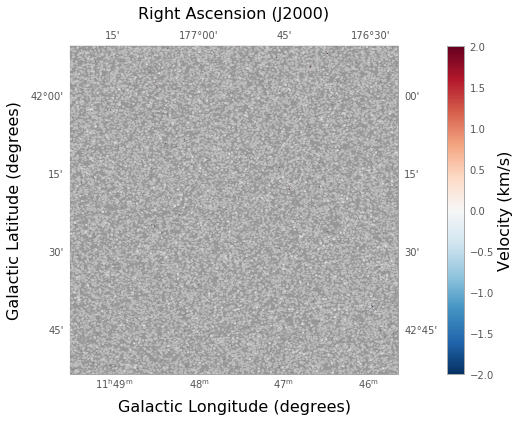

In [145]:
plot_cube(noise_cube, vmin=-2, vmax=2, rest_value=rest_freq, velocity_convention=u.doppler_radio)

HI signal cube

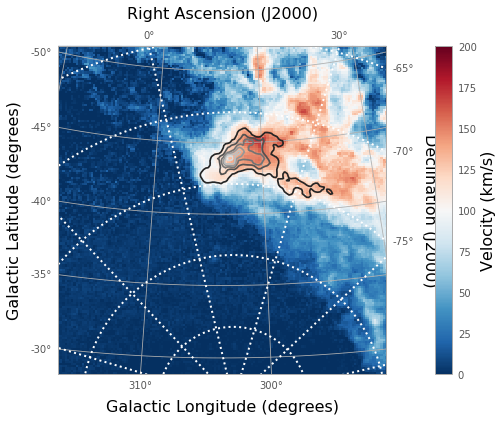

In [146]:
# If you want to take a subcube
# _, b, _ = cube.world[0, :, 0]  #extract latitude world coordinates from cube
# _, _, l = cube.world[0, 0, :]  #extract longitude world coordinates from cube
# # Define desired latitude and longitude range
# lat_range = [-46, -40] * u.deg
# lon_range = [306, 295] * u.deg

# Create a sub_cube cut to these coordinates
# sub_cube = cube.subcube(xlo=lon_range[0], xhi=lon_range[1], ylo=lat_range[0], yhi=lat_range[1])
# sub_cube_slab = sub_cube.spectral_slab(-300. *u.km / u.s, 300. *u.km / u.s)
plot_cube(hi_cube)

# Traditional Methods

In [84]:
pic = moment_1.hdu.data

## Thresholding

In [104]:
pic.shape

(150, 150)

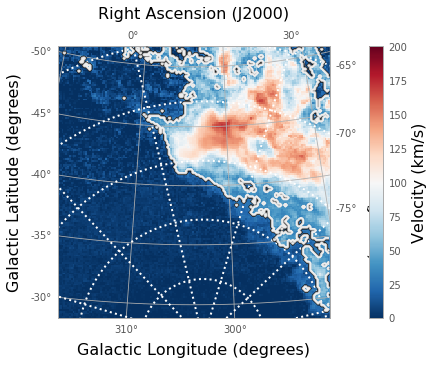

In [102]:
# text_threshold = filters.threshold_local(pic, block_size=51, offset=20)
plot_moment(pic, pic > np.mean(pic))

## Edge-based segmentation

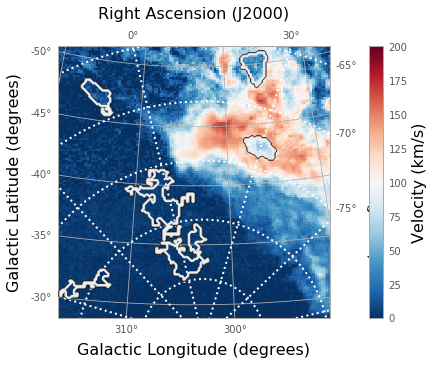

In [86]:
edges = canny(pic)
fill = ndi.binary_fill_holes(edges)
cleaned = morphology.remove_small_objects(fill, 100)
plot_moment(pic, cleaned)

## Region-based segmentation


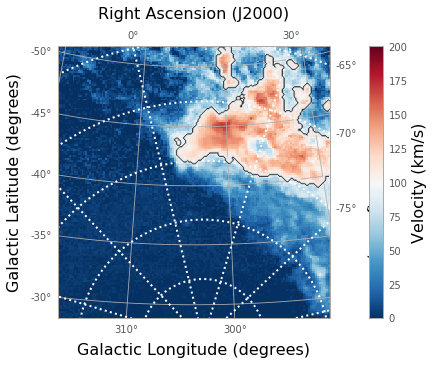

In [87]:
elevation_map = filters.sobel(pic)
markers = np.zeros_like(pic)
markers[pic < 100] = 1
markers[pic > 100] = 2
segmentated = segmentation.watershed(elevation_map, markers)
segmentated = ndi.binary_fill_holes(segmentated - 1)
plot_moment(pic, segmentated)

# Unspervised Segmentation

## K Means Clustering

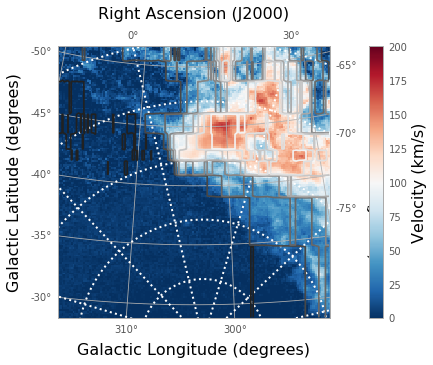

In [91]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(pic)
cluster_pic = kmeans.cluster_centers_[kmeans.labels_]
plot_moment(pic, cluster_pic)

## SLIC( Simple Linear Iterative Clustering)
based on K means clustering

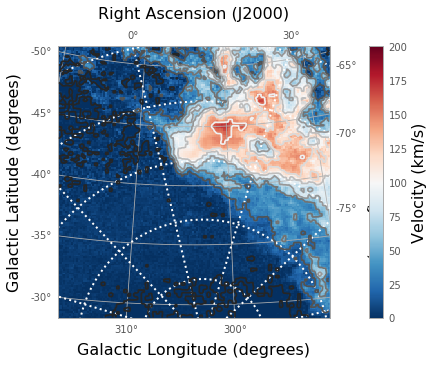

In [92]:
image_slic = segmentation.slic(pic, n_segments=8000)
plot_moment(pic, color.label2rgb(image_slic, pic, kind='avg'))

## Supervised Learning

## Random Forests